# Performance showcase of added "to_sql" functionality in mlinspect

Here the performance of the proposed inspection using sql will be compared to the original one in pandas. Part of
the "healthcare" and "compas" pipeline will be used.

## Required packages:
See: requirements/requirements.txt and requirements/requirements.dev.txt

## Some parameters you might want to set:

In [1]:
import os
import sys
import time

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from mlinspect.utils import get_project_root
from mlinspect import PipelineInspector, OperatorType
from mlinspect.inspections import HistogramForColumns, RowLineage, MaterializeFirstOutputRows
from mlinspect.checks import NoBiasIntroducedFor, NoIllegalFeatures
from demo.feature_overview.no_missing_embeddings import NoMissingEmbeddings
from example_pipelines.healthcare import custom_monkeypatching
from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector

from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector


# DBMS related:
UMBRA_USER = "postgres"
UMBRA_PW = ""
UMBRA_DB = ""
UMBRA_PORT = 5433
UMBRA_HOST = "/tmp/"

POSTGRES_USER = "luca"
POSTGRES_PW = "password"
POSTGRES_DB = "healthcare_benchmark"
POSTGRES_PORT = 5432
POSTGRES_HOST = "localhost"

HEALTHCARE_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "healthcare", "healthcare.py")
COMPAS_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "compas", "compas.py")
ADULT_SIMPLE_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "adult_simple", "adult_simple.py")
ADULT_COMPLEX_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "adult_complex", "adult_complex.py")

# No model training:
HEALTHCARE_FILE_PY_R = os.path.join(str(get_project_root()), "test", "monkeypatchingSQL", "pipelines_for_tests",
                                    "healthcare", "healthcare_res.py")
COMPAS_FILE_PY_R = os.path.join(str(get_project_root()), "test", "monkeypatchingSQL", "pipelines_for_tests", "compas",
                              "compas_res.py")
ADULT_SIMPLE_FILE_PY_R = os.path.join(str(get_project_root()), "test", "monkeypatchingSQL", "pipelines_for_tests",
                                    "adult_simple", "adult_simple_res.py")
ADULT_COMPLEX_FILE_PY_R = os.path.join(str(get_project_root()), "test", "monkeypatchingSQL", "pipelines_for_tests",
                                     "adult_complex", "adult_complex_res.py")

HEALTHCARE_BIAS = ['age_group', 'race']
COMPAS_BIAS = ['sex', 'race']
ADULT_SIMPLE_BIAS = ['race']

## Benchmark setup:

In [2]:
def run_inspection(file_location, bias, to_sql, dbms_connector=None, mode=None, materialize=None):
    from PIL import Image
    import matplotlib.pyplot as plt
    from mlinspect.visualisation import save_fig_to_path

    inspector_result = PipelineInspector \
        .on_pipeline_from_py_file(file_location) \
        .add_custom_monkey_patching_module(custom_monkeypatching) \
        .add_check(NoBiasIntroducedFor(bias)) \
        .add_check(NoIllegalFeatures()) \
        .add_check(NoMissingEmbeddings()) \
        .add_required_inspection(RowLineage(5)) \
        .add_required_inspection(MaterializeFirstOutputRows(5))

    if to_sql:
        inspector_result = inspector_result.execute_in_sql(dbms_connector=dbms_connector, mode=mode,
                                                           materialize=materialize)
    else:
        inspector_result = inspector_result.execute()

    extracted_dag = inspector_result.dag
    filename = os.path.join(str(get_project_root()), "demo", "feature_overview", "healthcare.png")
    save_fig_to_path(extracted_dag, filename)
    im = Image.open(filename)
    plt.imshow(im)

    check_results = inspector_result.check_to_check_results
    no_bias_check_result = check_results[NoBiasIntroducedFor(bias)]

    distribution_changes_overview_df = NoBiasIntroducedFor.get_distribution_changes_overview_as_df(
        no_bias_check_result)
    result = ""
    result += distribution_changes_overview_df.to_markdown()

    for i in list(no_bias_check_result.bias_distribution_change.items()):
        _, join_distribution_changes = i
        for column, distribution_change in join_distribution_changes.items():
            result += "\n"
            result += f"\033[1m Column '{column}'\033[0m"
            result += distribution_change.before_and_after_df.to_markdown()

    print(result)
    return result

## Benchmark of default inspection using CTEs:

In [3]:
dbms_connector_u = UmbraConnector(dbname=UMBRA_DB, user=UMBRA_USER, password=UMBRA_PW, port=UMBRA_PORT, host=UMBRA_HOST)

dbms_connector_p = PostgresqlConnector(dbname=POSTGRES_DB, user=POSTGRES_USER, password=POSTGRES_PW,
                                       port=POSTGRES_PORT, host=POSTGRES_HOST)

def run_for_all(file_location, bias, mode="", materialize=None):
    t0 = time.time()
    run_inspection(file_location=file_location, bias=bias, to_sql=False)
    t1 = time.time()
    print("\nTime spend with original (pandas): " + str(t1 - t0))

    t0 = time.time()
    run_inspection(file_location=file_location, bias=bias, to_sql=True, dbms_connector=dbms_connector_p, mode=mode,
                   materialize=materialize)
    t1 = time.time()
    print("\nTime spend with modified SQL inspections (PSQL): " + str(t1 - t0))

    if not materialize: # Materialized not supported by Umbra -> main-memory performance
        t0 = time.time()
        run_inspection(file_location=file_location, bias=bias, to_sql=True, dbms_connector=dbms_connector_u, mode=mode,
                       materialize=materialize)
        t1 = time.time()
        print("\nTime spend with modified SQL inspections (Umbra): " + str(t1 - t0))


## End-to-End example of the preprocessing-pipeline inspection + model training:

Slightly different inspections results are expected because of the random split. Still, the resulting model accuracy should
be similar.

2022-04-22 15:35:05.609528: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64
2022-04-22 15:35:05.609548: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 15:35:06.715263: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-22 15:35:06.759023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 15:35:06.759386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz co

Mean accuracy: 0.931506872177124
|    | operator_type            | description                                                                                                                                     | code_reference                                                            | source_code                                                                                                                   | module                                                                     | 'age_group' distribution change below the configured minimum test threshold   | 'race' distribution change below the configured minimum test threshold   |
|---:|:-------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------

Mean accuracy: 0.9178082346916199
|    | operator_type            | description                                                                                                                                     | code_reference                                                            | source_code                                                                                                                   | module                                                                     | 'age_group' distribution change below the configured minimum test threshold   | 'race' distribution change below the configured minimum test threshold   |
|---:|:-------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------

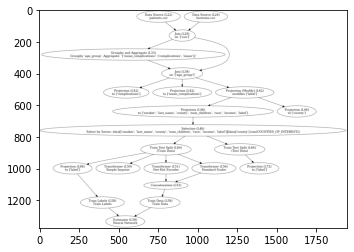

In [4]:
run_for_all(HEALTHCARE_FILE_PY, HEALTHCARE_BIAS, mode="VIEW", materialize=True)

## Execute and inspect just the inspections:

|    | operator_type            | description                                                       | code_reference                                                            | source_code                                     | module                                                                     | 'age_group' distribution change below the configured minimum test threshold   | 'race' distribution change below the configured minimum test threshold   |
|---:|:-------------------------|:------------------------------------------------------------------|:--------------------------------------------------------------------------|:------------------------------------------------|:---------------------------------------------------------------------------|:------------------------------------------------------------------------------|:-------------------------------------------------------------------------|
|  0 | OperatorType.JOIN        | on '['ssn']'                                  

|    | operator_type            | description                                                       | code_reference                                                            | source_code                                     | module                                                                     | 'age_group' distribution change below the configured minimum test threshold   | 'race' distribution change below the configured minimum test threshold   |
|---:|:-------------------------|:------------------------------------------------------------------|:--------------------------------------------------------------------------|:------------------------------------------------|:---------------------------------------------------------------------------|:------------------------------------------------------------------------------|:-------------------------------------------------------------------------|
|  0 | OperatorType.JOIN        | on '['ssn']'                                  

|    | operator_type            | description                                                       | code_reference                                                            | source_code                                     | module                                                                     | 'age_group' distribution change below the configured minimum test threshold   | 'race' distribution change below the configured minimum test threshold   |
|---:|:-------------------------|:------------------------------------------------------------------|:--------------------------------------------------------------------------|:------------------------------------------------|:---------------------------------------------------------------------------|:------------------------------------------------------------------------------|:-------------------------------------------------------------------------|
|  0 | OperatorType.JOIN        | on '['ssn']'                                  

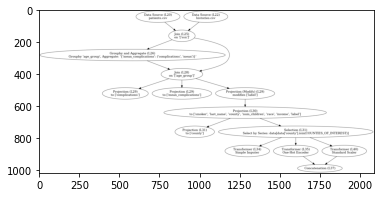

In [5]:
run_for_all(HEALTHCARE_FILE_PY_R, HEALTHCARE_BIAS, mode="CTE", materialize=None)


|    | operator_type          | description                                                                                                                  | code_reference                                                             | source_code                                                                                                | module                                                                | 'sex' distribution change below the configured minimum test threshold   | 'race' distribution change below the configured minimum test threshold   |
|---:|:-----------------------|:-----------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------|:-----------------

|    | operator_type          | description                                                                                                                  | code_reference                                                             | source_code                                                                                                | module                                                                | 'sex' distribution change below the configured minimum test threshold   | 'race' distribution change below the configured minimum test threshold   |
|---:|:-----------------------|:-----------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------|:-----------------

|    | operator_type          | description                                                                                                                  | code_reference                                                             | source_code                                                                                                | module                                                                | 'sex' distribution change below the configured minimum test threshold   | 'race' distribution change below the configured minimum test threshold   |
|---:|:-----------------------|:-----------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------|:-----------------

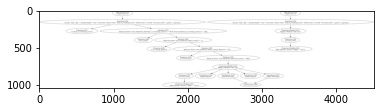

In [6]:
run_for_all(COMPAS_FILE_PY_R, COMPAS_BIAS, mode="CTE", materialize=None)







pipeline start
|    | operator_type          | description   | code_reference                                                           | source_code       | module                                                           | 'race' distribution change below the configured minimum test threshold   |
|---:|:-----------------------|:--------------|:-------------------------------------------------------------------------|:------------------|:-----------------------------------------------------------------|:-------------------------------------------------------------------------|
|  0 | OperatorType.SELECTION | dropna        | CodeReference(lineno=14, col_offset=7, end_lineno=14, end_col_offset=24) | raw_data.dropna() | FunctionInfo(module='pandas.core.frame', function_name='dropna') | False                                                                    |
 Column 'race'|    | sensitive_column_value   |   count_before |   count_after |   ratio_before |   ratio_after |   relative_ratio

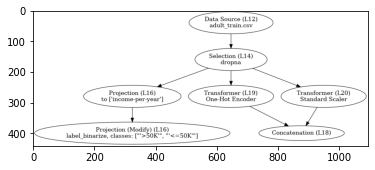

In [7]:
run_for_all(ADULT_SIMPLE_FILE_PY_R, ADULT_SIMPLE_BIAS, mode="CTE", materialize=None)







| operator_type   | description   | code_reference   | source_code   | module   | 'race' distribution change below the configured minimum test threshold   |
|-----------------|---------------|------------------|---------------|----------|--------------------------------------------------------------------------|

Time spend with original (pandas): 2.1468002796173096
| operator_type   | description   | code_reference   | source_code   | module   | 'race' distribution change below the configured minimum test threshold   |
|-----------------|---------------|------------------|---------------|----------|--------------------------------------------------------------------------|

Time spend with modified SQL inspections (PSQL): 0.4080348014831543
| operator_type   | description   | code_reference   | source_code   | module   | 'race' distribution change below the configured minimum test threshold   |
|-----------------|---------------|------------------|---------------|----------|----------

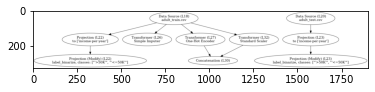

In [9]:
run_for_all(ADULT_COMPLEX_FILE_PY_R, ADULT_SIMPLE_BIAS, mode="CTE", materialize=None)





